# Song2Vec for Music Recommender

## Import Libraries

In [2]:
# Data Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_style("whitegrid")

# Modeling
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import PathLineSentences
from gensim.models.callbacks import CallbackAny2Vec
from util.spherical_kmeans import SphericalKMeans
from sklearn.manifold import TSNE
from scipy import stats

# Additional
import math
import os
import random
import multiprocessing
from tqdm import tqdm
from time import time
import logging
import pickle

C:\Users\marku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
MODEL_DIR = "../assets/model"
SONG2VEC_PATH = f"{MODEL_DIR}/song2vec.model"
SONG2VEC_KV_PATH = f"{MODEL_DIR}/song2vec.kv"
CORPUS_PATH = "../assets/tmp_sentences/" # /data
CONTINUE_TRAINING=True

In [4]:
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

class Callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 1
        self.training_loss = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 1:
            current_loss = loss
        else:
            current_loss = loss - self.loss_previous_step
        print(f"Loss after epoch {self.epoch}: {current_loss}")
        self.training_loss.append(current_loss)
        self.epoch += 1
        self.loss_previous_step = loss

#### Training

By using `gensim`, the training process can be separated into **three distinctive steps**: 

First, the instance of `Word2Vec()` is created to set up the parameters of the model and leave the model uninitialized.
- `size`: dimensionality of the song vectors
- `window`: maximum distance between context and target
- `min_count`: frequency cut-off for a song to be considered in the model
- `sg = 0`: using CBOW architecture
- `negative`: negative sampling data
- `workers`: number of CPU used to train the model

In [5]:
model = None
if (os.path.isfile(SONG2VEC_PATH)) and not CONTINUE_TRAINING:
	model = Word2Vec.load(SONG2VEC_PATH)
else:
	model = Word2Vec(
		vector_size=256,
		window=10,
		min_count=1,
		max_vocab_size=None,  # 70M unique songs at most 7G ram:  https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.LineSentence
		sg=0,
		negative=20,
		workers=multiprocessing.cpu_count()-1)

	logging.disable(logging.NOTSET)  # enable logging
	assert os.path.isdir(CORPUS_PATH)
	sentences = PathLineSentences(CORPUS_PATH)
	t = time()
	model.build_vocab(corpus_iterable=sentences, progress_per=1e5)
	print(f"Time to build vocab: {round((time() - t), 2)} seconds")

	logging.disable(logging.INFO)  # disable logging
	callback = Callback()  # instead, print out loss for each epoch
	t = time()

	# TODO: Consider PathLineSentences: https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.PathLineSentences
	model.train(corpus_iterable=sentences,
				total_examples=model.corpus_count,
				epochs=50, # Google News Word2Vec takes billions of examples but only ~20 epochs
				compute_loss=True,
				callbacks=[callback])

	print(f"Time to train the model: {round((time() - t), 2)} seconds")

	logging.disable(logging.INFO)  # disable logging
	model.save(SONG2VEC_PATH)
	model.wv.save(SONG2VEC_KV_PATH)

	# Loss evaluation - Loss (y) vs Epoch (x)
	plt.plot(range(1, model.epochs+1), callback.training_loss)
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.title("Training Loss", fontweight = "bold")
	plt.show()

print(model)


2021-07-09 22:12:46,284 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=256, alpha=0.025)', 'datetime': '2021-07-09T22:12:46.265621', 'gensim': '4.0.1', 'python': '3.9.6 (tags/v3.9.6:db3ff76, Jun 28 2021, 15:26:21) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}
2021-07-09 22:12:46,287 : INFO : reading directory ../assets/tmp_sentences/
2021-07-09 22:12:46,288 : INFO : files read into PathLineSentences:../assets/tmp_sentences/spotify_sentences.txt
../assets/tmp_sentences/spscraped_179000.txt
../assets/tmp_sentences/spscraped_sentences.txt
2021-07-09 22:12:46,289 : INFO : collecting all words and their counts
2021-07-09 22:12:46,291 : INFO : reading file ../assets/tmp_sentences/spotify_sentences.txt
2021-07-09 22:12:46,292 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-07-09 22:12:50,992 : INFO : PROGRESS: at sentence #100000, processed 9109646 words, keeping 890625 word types
2021-07

Time to build vocab: 61.84 seconds
Loss after epoch 1: 6114776.5
Loss after epoch 2: 2599245.5
Loss after epoch 3: 2157591.0
Loss after epoch 4: 1932173.0
Loss after epoch 5: 1833118.0


The plot above shows five most similar songs to `song_id = '4162'` (Maroon 5 - She Will Be Loved). Up until now, the model can be used for recommending new songs using cosine similarity, but only based on one main song.

That being said, let's perform Spherical K-Means on the song vectors by iterating the number of clusters from 10 to 500 so that the optimal number of clusters `k_opt` can be chosen by the elbow method.

In [ ]:
embedding_matrix = model.wv[model.wv.key_to_index.keys()]
embedding_matrix.shape

NameError: name 'model' is not defined

In [ ]:
range_k_clusters = (10, 500)
skm_list = []
for k in tqdm(range(*range_k_clusters, 10)):
    skm = SphericalKMeans(n_clusters = k,
                          n_init = 5, n_jobs = -1,
                          random_state = 123).fit(embedding_matrix)
    
    result_dict = {
        "k": k,
        "WCSS": skm.inertia_,
        "skm_object": skm
    }
    
    skm_list.append(result_dict)
skm_df = pd.DataFrame(skm_list).set_index('k')
skm_df.head()

  8%|▊         | 4/49 [04:19<48:36, 64.82s/it]


KeyboardInterrupt: 

In [ ]:
def save2Pickle(obj, filename):
    with open(f"{MODEL_PATH}{filename}.pkl", "wb") as file:
        pickle.dump(obj, file)

def loadPickle(filename):
    with open(f"{MODEL_PATH}{filename}.pkl", "rb") as file:
        return pickle.load(file)

In [ ]:
save2Pickle(skm_df, "skm_cluster")

NameError: name 'skm_df' is not defined

In [ ]:
skm_df = loadPickle("skm_cluster")

NameError: name 'loadPickle' is not defined

In [ ]:
skm_df.WCSS.plot()
plt.xlabel("No. of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method", fontweight = "bold")
plt.show()

NameError: name 'skm_df' is not defined

How to locate the optimal number of clusters objectively? Here is the idea:

<img src="assets/elbow-method.png" width="400">
<center><a href="https://www.researchgate.net/figure/Example-of-the-elbow-criterion-applied-over-the-curve-of-within-class-sum-of-squares-per_fig1_282000605">Elbow Method</a></center>

1. Connect the first and last point of the curve with a straight line
2. Calculate the perpendicular distance from each point to that line
3. Consider the longest distance as the elbow

In [ ]:
def locateOptimalElbow(x, y):
    # START AND FINAL POINTS
    p1 = (x[0], y[0])
    p2 = (x[-1], y[-1])
    
    # EQUATION OF LINE: y = mx + c
    m = (p2[1] - p1[1]) / (p2[0] - p1[0])
    c = (p2[1] - (m * p2[0]))
    
    # DISTANCE FROM EACH POINTS TO LINE mx - y + c = 0
    a, b = m, -1
    dist = np.array([abs(a*x0+b*y0+c)/math.sqrt(a**2+b**2) for x0, y0 in zip(x,y)])
    return x[np.argmax(dist)]

In [ ]:
k_opt = locateOptimalElbow(skm_df.index, skm_df['WCSS'].values)
skm_opt = skm_df.loc[k_opt, "skm_object"]
skm_opt

NameError: name 'skm_df' is not defined

In [ ]:
songs_cluster = songs.copy()
songs_cluster.loc[model.wv.vocab.keys(), 'cluster'] = skm_opt.labels_
songs_cluster['cluster'] = songs_cluster['cluster'].fillna(-1).astype('int').astype('category')

NameError: name 'skm_opt' is not defined

In the end, the optimal number of clusters is set to be 110. There is a possibility that some songs don't have the embedded vectors since the `playlist` is split to train and test. For this case, assign the cluster as -1 instead.

#### Visualize Clusters

It is always quite helpful to visualize the embeddings that have been created. Over here, we have song vectors with 256 dimensions. These high-dimensional vectors can't be visualized in our 3D world, so using dimensionality reduction algorithms such as **t-Distributed Stochastic Neighbor Embedding (t-SNE)** helps us map the vectors to a lower dimension. The mathematical detail of t-SNE will not be presented here, but in practice, it tends to produce a visualization with distinctly isolated clusters.

In [ ]:
embedding_tsne = TSNE(n_components = 2, metric = 'cosine',
                      random_state = 123).fit_transform(embedding_matrix)

In [ ]:
save2Pickle(embedding_tsne, "tsne_viz")

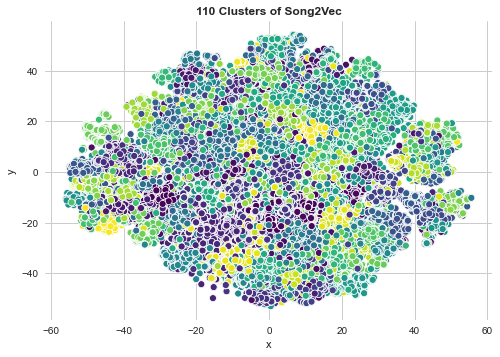

In [ ]:
embedding_tsne = loadPickle("tsne_viz")
songs_cluster.loc[model.wv.vocab.keys(), 'x'] = embedding_tsne[:,0]
songs_cluster.loc[model.wv.vocab.keys(), 'y'] = embedding_tsne[:,1]
sns.scatterplot(data = songs_cluster[songs_cluster['cluster'] != -1],
                x = 'x', y = 'y', palette = "viridis",
                hue = 'cluster', legend = False).set_title(f"{k_opt} Clusters of Song2Vec",
                                                           fontweight = "bold")
plt.show()

The cluster might look cluttered since all 110 clusters are being plotted at once. Instead, let's just perform t-SNE on randomly selected 10 clusters and visualize the result.

In [ ]:
random.seed(100)
random_cluster2plot = random.sample(range(k_opt), 10)
random_songs = songs_cluster[songs_cluster.cluster.isin(random_cluster2plot)].copy()
random_tsne = TSNE(n_components = 2, metric = 'cosine',
                   random_state = 100).fit_transform(model.wv[random_songs.index])
random_songs.loc[random_songs.index, 'x'] = random_tsne[:,0]
random_songs.loc[random_songs.index, 'y'] = random_tsne[:,1]

g = sns.scatterplot(data = random_songs,
                x = 'x', y = 'y', palette = "viridis",
                hue = 'cluster')
g.legend(loc = "upper left", bbox_to_anchor = (1, 1))
g.set_title(f"Randomly selected {len(random_cluster2plot)} clusters of Song2Vec", fontweight = "bold")
plt.show()

NameError: name 'k_opt' is not defined

Songs that have similar context (by cosine similarity) tend to be plotted next to each other. Thus, creating distinct song clusters. Note that the clusters might look overlap to each other due to the dimensionality reduction, but in the actual dimension, they do not.

## Start Recommending

Congratulations! We are finally ready with the embeddings for every song that exists in `playlist_train`. How these song vectors are then used to suggest similar songs based on a certain playlist? One way is to calculate a **playlist vector** for each playlist by averaging together all the song vectors in that playlist. These vectors then become the query to find similar songs based on cosine similarity. Here is an illustration using a users' music streaming playlist:

<img src="assets/playlist-vector.gif" width="500">
<center><a href="https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484">Song2Vec Average</a></center>

For each playlist in `playlist_test`, calculate the average vectors using `meanVectors()` function. If the song hasn't been embedded before, neglect the song instead.

In [ ]:
def meanVectors(playlist):
    vec = []
    for song_id in playlist:
        try:
            vec.append(model.wv[song_id])
        except KeyError:
            continue
    return np.mean(vec, axis=0)

In [ ]:
playlist_vec = list(map(meanVectors, playlist_test))

For each playlist vector, recommend top $n$ similar songs based on the cosine similarity.

In [ ]:
def similarSongsByVector(vec, n = 10, by_name = True):
    # extract most similar songs for the input vector
    similar_songs = model.wv.similar_by_vector(vec, topn = n)
    
    # extract name and similarity score of the similar products
    if by_name:
        similar_songs = [(songs.loc[song_id, "artist - title"], sim)
                              for song_id, sim in similar_songs]
    
    return similar_songs

Let's test the song embeddings to recommend top 10 songs for `playlist_test` in index `305`.

In [ ]:
def print_recommended_songs(idx, n):
    print("============================")
    print("SONGS PLAYLIST")
    print("============================")
    for song_id in playlist_test[idx]:
        print(songs.loc[song_id, "artist - title"])
    print()
    print("============================")
    print(f"TOP {n} RECOMMENDED SONGS")
    print("============================")
    for song, sim in similarSongsByVector(playlist_vec[idx], n):
        print(f"[Similarity: {sim:.3f}] {song}")
    print("============================")

In [ ]:
print_recommended_songs(idx = 305, n = 10)

SONGS PLAYLIST
Selena - Como La Flor
The Texas Tornados - Who Were You Thinkin' Of
Selena - Sentimientos

TOP 10 RECOMMENDED SONGS
[Similarity: 0.835] Selena - Como La Flor
[Similarity: 0.779] Selena - Sentimientos
[Similarity: 0.763] Little Joe Y La Familia - Borrachera
[Similarity: 0.751] Lorenzo Antonio - Con La Misma Espina
[Similarity: 0.745] Tierra Tejana - Eres Casado
[Similarity: 0.742] Jennifer Y Los Jetz - Me Piden
[Similarity: 0.730] The Texas Tornados - (Hey Baby) Que Paso
[Similarity: 0.712] The Texas Tornados - Who Were You Thinkin' Of
[Similarity: 0.709] Ruben Vela - La Papaya
[Similarity: 0.704] Sparx - Lo Dice Mi Corazon


Interestingly, the model is able to capture and recommend new songs based on the "Spanish" genre from `playlist_test` indexed at `305` without being explicitly stated. Great! The final step is to evaluate how this recommender performs.

## Evaluation

One way to evaluate the performance of a recommender system is by computing **hit rate** as follows:
1. For each song in a playlist, intentionally **Leave-One-Out (LOO)** this song.
2. By using several systems below, try to guess the LOO song.
3. Ask the recommender for top $n$ recommended songs.
4. If the LOO song appears in the top $n$ recommendation, consider it as a **HIT**. Otherwise not.
5. Repeat the LOO process until the end of the playlist. Then, the hit rate of a playlist is calculated by dividing the number of HIT with the length of a playlist.
6. Repeat step 1-5 for all playlist in `playlist_test` and calculate the **Average Hit Rate at $n$ (AHR@n)**.

In [ ]:
top_n_songs = 25

### Random Recommender

As a baseline, let's try to guess the LOO song randomly without any system.

In [ ]:
def hitRateRandom(playlist, n_songs):
    hit = 0
    for i, target in enumerate(playlist):
        random.seed(i)
        recommended_songs = random.sample(list(songs.index), n_songs)
        hit += int(target in recommended_songs)
    return hit/len(playlist)

In [ ]:
eval_random = pd.Series([hitRateRandom(p, n_songs = top_n_songs)
                         for p in tqdm(playlist_test, position=0, leave=True)])
eval_random.mean()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [35:58<00:00,  2.16s/it]


0.00030413731380910425

### Song Tags Recommender

It is possible to recommend based on song tags provided on the data as follows:
1. Create a list of song `tag_names` that surrounds the LOO song. The maximum distance between the LOO and context songs is defined by `window`.
2. List all possible songs from the list.
3. Take $n$ songs randomly from the possible songs list.

In [ ]:
mapping_tag2song = songs.explode('tag_names').reset_index().groupby('tag_names')['song_id'].apply(list)
mapping_tag2song

tag_names
00s           [16, 23, 28, 30, 38, 41, 46, 49, 55, 58, 68, 8...
10s           [6, 13, 14, 18, 19, 27, 46, 51, 57, 59, 60, 62...
1960s         [516, 612, 622, 626, 629, 897, 1336, 1337, 137...
1970s         [499, 500, 522, 537, 608, 615, 618, 619, 881, ...
1980s         [501, 502, 536, 556, 618, 837, 1378, 1505, 150...
                                    ...                        
usa           [47, 52, 91, 187, 194, 197, 201, 298, 324, 382...
vocal         [14, 91, 96, 97, 125, 194, 201, 386, 407, 424,...
vocal jazz    [42, 592, 599, 872, 908, 1043, 1097, 1104, 117...
wjlb-fm       [0, 1, 2, 4, 5, 6, 8, 14, 18, 19, 20, 22, 25, ...
worship       [104, 106, 384, 566, 643, 732, 737, 1109, 1115...
Name: song_id, Length: 251, dtype: object

In [ ]:
def hitRateContextSongTag(playlist, window, n_songs):
    hit = 0
    context_target_list = [([playlist[w] for w in range(idx-window, idx+window+1)
                             if not(w < 0 or w == idx or w >= len(playlist))], target)
                           for idx, target in enumerate(playlist)]
    for i, (context, target) in enumerate(context_target_list):
        context_song_tags = set(songs.loc[context, 'tag_names'].explode().values)
        possible_songs_id = set(mapping_tag2song[context_song_tags].explode().values)
        
        random.seed(i)
        recommended_songs = random.sample(possible_songs_id, n_songs)
        hit += int(target in recommended_songs)
    return hit/len(playlist)

In [ ]:
eval_song_tag = pd.Series([hitRateContextSongTag(p, model.window, n_songs = top_n_songs)
                           for p in tqdm(playlist_test, position=0, leave=True)])
eval_song_tag.mean()

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:26:35<00:00,  5.20s/it]


0.0005425495180688559

### Cluster-based Recommender

To improve further, let's utilize the result of clustering in the modeling section:
1. Identify which cluster number is the most frequent (by majority voting) in surrounding songs. The maximum distance between the LOO and context songs is defined by `window`.
2. List out possible songs from that majority cluster.
3. Take $n$ songs randomly from the possible songs list.

In [ ]:
def hitRateClustering(playlist, window, n_songs):
    hit = 0
    context_target_list = [([playlist[w] for w in range(idx-window, idx+window+1)
                             if not(w < 0 or w == idx or w >= len(playlist))], target)
                           for idx, target in enumerate(playlist)]
    for context, target in context_target_list:
        cluster_numbers = skm_opt.predict([model.wv[c] for c in context if c in model.wv.vocab.keys()])
        majority_voting = stats.mode(cluster_numbers).mode[0]
        possible_songs_id = list(songs_cluster[songs_cluster['cluster'] == majority_voting].index)
        recommended_songs = random.sample(possible_songs_id, n_songs)
        songs_id = list(zip(*recommended_songs))[0]
        hit += int(target in songs_id)
    return hit/len(playlist)

In [ ]:
eval_clust = pd.Series([hitRateClustering(p, model.window, n_songs = top_n_songs)
                           for p in tqdm(playlist_test, position=0, leave=True)])
eval_clust.mean()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:20<00:00,  4.98it/s]


0.005054657281168753

### Song2Vec Recommender

Lastly, evaluate the CBOW Song2Vec model as follows:
1. Take the average vectors of surrounding context songs using previously defined `meanVectors()` function. The maximum distance is defined by `window`.
2. Find top $n$ similar songs based on cosine similarity using `similarSongsByVector()` function.

In [ ]:
def hitRateSong2Vec(playlist, window, n_songs):
    hit = 0
    context_target_list = [([playlist[w] for w in range(idx-window, idx+window+1)
                             if not(w < 0 or w == idx or w >= len(playlist))], target)
                           for idx, target in enumerate(playlist)]
    for context, target in context_target_list:
        context_vector = meanVectors(context)
        recommended_songs = similarSongsByVector(context_vector, n = n_songs, by_name = False)
        songs_id = list(zip(*recommended_songs))[0]
        hit += int(target in songs_id)
    return hit/len(playlist)

In [ ]:
eval_song2vec = pd.Series([hitRateSong2Vec(p, model.window, n_songs = top_n_songs)
                           for p in tqdm(playlist_test, position=0, leave=True)])
eval_song2vec.mean()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:13<00:00,  1.03it/s]


0.11958469298590102

### Comparison

Finally, we compare the calculated Average Hit Rate at 25 (AHR@25) of the four recommender systems. The higher the AHR, the better is the system. From the bar plot below, Song2Vec outperforms other methods in terms of hit rate, which means that it can recommend a song well based on surrounding context songs. In a real-life scenario, this system may likely to be low quality since the AHR is only around 10%, but still, it is much better than no recommender system at all.

In [ ]:
eval_df = pd.concat([eval_random.rename("Random"),
           eval_song_tag.rename("Song Tag"),
           eval_clust.rename("Clustering"),
           eval_song2vec.rename("Song2Vec")], axis = 1)
save2Pickle(eval_df, "eval_df")

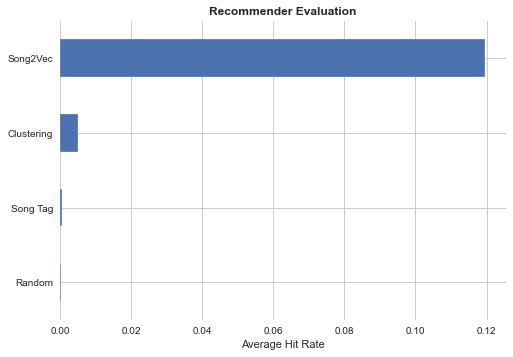

In [ ]:
eval_df = loadPickle("eval_df")
g = eval_df.mean().sort_values().plot(kind = 'barh')
g.set_xlabel("Average Hit Rate")
g.set_title("Recommender Evaluation", fontweight = "bold")
plt.show()

## Conclusion

Song2Vec is an implementation of Word2Vec which able to capture the context of a song based on surrounding songs in a playlist. In this notebook, we successfully exploit the sequential property of a playlist and represent each song with a 256-dimensional vector. This vector representation is then used as a recommender system based on cosine similarity score. The objective of a music recommender is to create accurate personalized recommendations from historical playlist or listening queue. Therefore, metric such as AHR@n is used to evaluate how many times (on average) a song is listed on the top-$n$ recommended songs based on surrounding context songs.

Things to be taken carefully when applying Song2Vec on its own is the cold start problem, a condition where it is impossible to recommend any songs to a new user or even recommend a new song to any users. This can be efficiently handled by combining the recommender using a content-based technique, which utilizes explicit features or characteristics of the songs as demonstrated in the "Song Tags Recommender" section.

Maybe you're wondering what are other implementations of Word2Vec? Here is the list for you: 
- Product recommendations: Using purchase receipts in a transaction to capture an item embeddings to learn the user's purchase activity.
- Listing recommendations: The user activity is in the form of click data, which can be represented as a sequence of listings that a user viewed.
- Matching advertisement to search query: Data consist of sequential search sessions, including entered query, clicked advertisement, and search results.